# Diabetes Mellitus in Pima Indians

## Content


Diabetes mellitus is a chronic disease characterized by hyperglycemia. This data set predicted the occurance of diabetes in Pima Indians. 
Data set can be found at : http://121.42.167.206/PIMAINDIANS/data.html


# Attributes

There are 768 samples with 9 variables. The variables are:
         1. pregnant, number of times pregnant
         2. glucose, plasma glucose concentration (glucose tolerance test)
         3. pressure, diastolic blood pressure (mm/Hg)
         4. triceps,triceps skin fold thickness (mm)
         5. insulin, 2-Hour serum insulin (mu U/ml)
         6. BMI, body mass index (weight in kg/(height in m)\^2)
         7. pedigree, diabetes pedigree function
         8. age, age (years)
         9. diabetes, class variable (test for diabetes)
         
   Target column is : *diabetes*

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sys

print("Python version is "+sys.version)
print("Matplotlib version is "+matplotlib.__version__)
print("Scikit-Learn version is "+sklearn.__version__)
print("Numpy version is "+np.__version__)
print("Pandas version is "+pd.__version__)

Python version is 3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]
Matplotlib version is 3.0.2
Scikit-Learn version is 0.21.1
Numpy version is 1.15.4
Pandas version is 0.23.4


In [3]:
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
#from sklearn.ensemble import ExtraTreesClassifier

## Fetching Data

In [4]:
df = pd.read_csv('pima-indians-diabetes.csv')
#col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
#del df['insulin']
df.head(5)

,pregnant,glucose,pressure,triceps,insulin,bmi,pedigree,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
data = df.values
X = data[:,:-1]  
y = data[:,-1] #column -1 is the dependent variable
print(X.shape)

(768, 8)


## Create a K-fold

In [6]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import confusion_matrix

k = 7
random_state = 1

In [7]:
kfold = KFold(n_splits=k, shuffle=True, random_state=random_state)

## Split the Data into Training and Testing Set

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(X_train.shape)
print(X_test.shape)

(576, 8)
(192, 8)


## Normalize Data

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

## Logistic Model

We use nested cross-validation to get more accurate performance for the model. 

A five-fold cross-validation is used to benchmark the model. The average scores and standard deviations are reported. In each fold, a three-fold grid search cross-validation is used to search best parameters. 

In [10]:
param_range = np.logspace(-4,4,num=9)
param_grid = [{'C': param_range}]

gs = GridSearchCV(estimator=LogisticRegression(tol=1e-4, solver='lbfgs'), 
                  param_grid=param_grid, 
                  cv=4,
                  iid=True,
                  n_jobs=-1)
scores = cross_validate(gs, X_std, y, 
                        scoring=['accuracy','f1','precision','recall'], 
                        return_train_score=True,
                        return_estimator=True,
                        cv=5,
                        n_jobs=-1)
print('CV train accuracy: %.3f +/- %.3f' % (np.mean(scores['train_accuracy']),
                                      np.std(scores['train_accuracy'])))
print('CV test accuracy: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']),
                                      np.std(scores['test_accuracy'])))
print('CV f1 score: %.3f +/- %.3f' % (np.mean(scores['test_f1']),
                                      np.std(scores['test_f1'])))
print('CV precision: %.3f +/- %.3f' % (np.mean(scores['test_precision']),
                                      np.std(scores['test_precision'])))
print('CV recall: %.3f +/- %.3f' % (np.mean(scores['test_recall']),
                                      np.std(scores['test_recall'])))
print('Best parameters for each fold: %s'%list(map(lambda e:e.best_params_['C'], scores['estimator'])))
#print(scores)
best_val_score = list(map(lambda e:e.best_score_, scores['estimator']))
print('Best validation scores (accuracy): %.3f +/- %.3f'%(np.mean(best_val_score), np.std(best_val_score)))


CV train accuracy: 0.779 +/- 0.006
CV test accuracy: 0.766 +/- 0.018
CV f1 score: 0.624 +/- 0.031
CV precision: 0.711 +/- 0.040
CV recall: 0.560 +/- 0.046
Best parameters for each fold: [100.0, 1.0, 10.0, 0.1, 0.1]
Best validation scores (accuracy): 0.769 +/- 0.005


## MLP Model

In [11]:
hls_range = [(m,n) for m in range(8,2,-1) for n in range(m,2,-1)]+[(n,) for n in range(8,2,-1)]
#print(hls_range)
alpha_range = np.logspace(-2,2,num=5)
#print(alpha_range)
param_grid = [{'alpha':alpha_range, 'hidden_layer_sizes':hls_range}]

'''mlp = MLPClassifier(hidden_layer_sizes=(9,9), tol = 1e-4, alpha=1e-4,
                    solver='adam', verbose=False, random_state=1,
                    learning_rate_init=.01, warm_start=True, max_iter=1000)'''

gs = GridSearchCV(estimator=MLPClassifier(tol=1e-4, solver='lbfgs', 
                                          learning_rate_init=0.02,
                                          max_iter=5000,
                                         random_state=1), 
                  param_grid=param_grid, 
                  cv=3,
                  iid=True,
                  n_jobs=-1)
scores = cross_validate(gs, X_std, y, 
                        scoring=['accuracy','f1','precision','recall'], 
                        return_train_score=True,
                        return_estimator=True,
                        cv=5,
                        n_jobs=-1)
print('CV train accuracy: %.3f +/- %.3f' % (np.mean(scores['train_accuracy']),
                                      np.std(scores['train_accuracy'])))
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']),
                                      np.std(scores['test_accuracy'])))
print('CV f1 score: %.3f +/- %.3f' % (np.mean(scores['test_f1']),
                                      np.std(scores['test_f1'])))
print('CV precision: %.3f +/- %.3f' % (np.mean(scores['test_precision']),
                                      np.std(scores['test_precision'])))
print('CV recall: %.3f +/- %.3f' % (np.mean(scores['test_recall']),
                                      np.std(scores['test_recall'])))
print('Best parameters for each fold: %s'%list(map(lambda e:e.best_params_, scores['estimator'])))
best_val_score = list(map(lambda e:e.best_score_, scores['estimator']))
print('Best validation scores (accuracy): %.3f +/- %.3f'%(np.mean(best_val_score), np.std(best_val_score)))

CV train accuracy: 0.792 +/- 0.009
CV accuracy: 0.772 +/- 0.023
CV f1 score: 0.637 +/- 0.044
CV precision: 0.718 +/- 0.039
CV recall: 0.575 +/- 0.060
Best parameters for each fold: [{'alpha': 10.0, 'hidden_layer_sizes': (8, 8)}, {'alpha': 10.0, 'hidden_layer_sizes': (6, 5)}, {'alpha': 10.0, 'hidden_layer_sizes': (8, 8)}, {'alpha': 10.0, 'hidden_layer_sizes': (8,)}, {'alpha': 10.0, 'hidden_layer_sizes': (7, 4)}]
Best validation scores (accuracy): 0.778 +/- 0.006


### Feature Selection

We use Logistic Regression to estimate the impact of each independent variable and the dependent variable.

Grid search cross-validation is used to find parameters that yield best accuracy. Since the goal is to find the best parameter rather than benchmark the performance of the model, we use all data set (rather than splitting data to training and test sets) to compute parameters. 

In [12]:
param_range = np.logspace(-4,4,num=17)
param_grid = [{'C': param_range}]

gs = GridSearchCV(estimator=LogisticRegression(tol=1e-4, solver='lbfgs'), 
                  param_grid=param_grid, 
                  cv=10,
                  iid=True,
                  n_jobs=-1)
gs.fit(X_std, y)
print(gs.best_params_)
print(gs.best_estimator_.coef_)
#print(logistic_model.coef_)

{'C': 1.0}
[[ 0.40864687  1.10711197 -0.25086804  0.00905046 -0.13083627  0.69630872
   0.30883724  0.17649782]]


## Gridsearch

In [13]:
from sklearn.svm import SVC

param_C_range = np.logspace(-4,1,num=6)
param_g_range = np.logspace(-2,1,num=4)
param_grid = [{'C': param_C_range, 
               'kernel': ['linear']},
              {'C': param_C_range, 
               'gamma': param_g_range, 
               'kernel': ['rbf']},
              {'C': param_C_range,
               'degree': [2,3],
               'kernel': ['poly']}]

gs = GridSearchCV(estimator=SVC(tol=1e-4), 
                  param_grid=param_grid, 
                  cv=3,
                  iid=True,
                  n_jobs=-1)
scores = cross_validate(gs, X_std, y, 
                        scoring=['accuracy','f1','precision','recall'], 
                        return_train_score=True,
                        return_estimator=True,
                        cv=5,
                        n_jobs=-1)
print('CV train accuracy: %.3f +/- %.3f' % (np.mean(scores['train_accuracy']),
                                      np.std(scores['train_accuracy'])))
print('CV test accuracy: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']),
                                      np.std(scores['test_accuracy'])))
print('CV f1 score: %.3f +/- %.3f' % (np.mean(scores['test_f1']),
                                      np.std(scores['test_f1'])))
print('CV precision: %.3f +/- %.3f' % (np.mean(scores['test_precision']),
                                      np.std(scores['test_precision'])))
print('CV recall: %.3f +/- %.3f' % (np.mean(scores['test_recall']),
                                      np.std(scores['test_recall'])))
print('Best parameters for each fold: %s'%list(map(lambda e:e.best_params_, scores['estimator'])))
#print(scores)
best_val_score = list(map(lambda e:e.best_score_, scores['estimator']))
print('Best validation scores (accuracy): %.3f +/- %.3f'%(np.mean(best_val_score), np.std(best_val_score)))

CV train accuracy: 0.789 +/- 0.010
CV test accuracy: 0.772 +/- 0.024
CV f1 score: 0.624 +/- 0.033
CV precision: 0.741 +/- 0.060
CV recall: 0.541 +/- 0.034
Best parameters for each fold: [{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}, {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}, {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}, {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}, {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}]
Best validation scores (accuracy): 0.775 +/- 0.008


## Random Forest

In [14]:
param_range = [20,22,24]
param_grid = [{'max_depth': param_range}]

gs = GridSearchCV(estimator=RandomForestClassifier(criterion='gini', n_estimators=100), 
                  param_grid=param_grid, 
                  cv=3,
                  iid=True,
                  n_jobs=-1)
scores = cross_validate(gs, X_std, y, 
                        scoring=['accuracy','f1','precision','recall'], 
                        return_train_score=True,
                        return_estimator=True,
                        cv=5,
                        n_jobs=-1)
print('CV train accuracy: %.3f +/- %.3f' % (np.mean(scores['train_accuracy']),
                                      np.std(scores['train_accuracy'])))
print('CV test accuracy: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']),
                                      np.std(scores['test_accuracy'])))
print('CV f1 score: %.3f +/- %.3f' % (np.mean(scores['test_f1']),
                                      np.std(scores['test_f1'])))
print('CV precision: %.3f +/- %.3f' % (np.mean(scores['test_precision']),
                                      np.std(scores['test_precision'])))
print('CV recall: %.3f +/- %.3f' % (np.mean(scores['test_recall']),
                                      np.std(scores['test_recall'])))
print('Best parameters for each fold: %s'%list(map(lambda e:e.best_params_['max_depth'], scores['estimator'])))
#print(scores)
best_val_score = list(map(lambda e:e.best_score_, scores['estimator']))
print('Best validation scores (accuracy): %.3f +/- %.3f'%(np.mean(best_val_score), np.std(best_val_score)))

CV train accuracy: 1.000 +/- 0.000
CV test accuracy: 0.755 +/- 0.037
CV f1 score: 0.616 +/- 0.060
CV precision: 0.684 +/- 0.065
CV recall: 0.564 +/- 0.070
Best parameters for each fold: [20, 20, 24, 20, 24]
Best validation scores (accuracy): 0.767 +/- 0.011


In [15]:
#clf = tree.DecisionTreeClassifier()
#clf = clf.fit(X_train_std, y_train)
clf = DecisionTreeClassifier(criterion='gini', 
                              max_depth=6, 
                              random_state=1)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

## Decision Tree

In [16]:
from sklearn.tree import export_graphviz
import graphviz 
from graphviz import Graph
import pydotplus

#dot_data = tree.export_graphviz(clf, out_file=None) 
#graph = graphviz.Source(dot_data)
dot_data = export_graphviz(clf, out_file=None, 
                    feature_names=['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age'],  
                    class_names=['Diabetic', 'No Diabetes'],  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = graphviz.Source(dot_data)  

g1 = pydotplus.graph_from_dot_data(dot_data)
g1.write_png('tree.png')

#plt.savefig('graph.png', dpi=300)


True

In [17]:
import graphviz as gv
from matplotlib import pyplot as plt


g1 = gv.Graph(format='png')
filename = g1.render(filename='g1.dot')

plt.savefig('filename.png')

<Figure size 432x288 with 0 Axes>

## Using PCA for Visualization

In [18]:
#features =['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age']

#data = df.values
#X = data[:,[2,3]] 
#y = data[:,-1]
#x = StandardScaler().fit_transform(X)

#print('Class labels:', np.unique(y))
#print(X.shape)

In [19]:
from sklearn.preprocessing import StandardScaler
#features = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age']
x = StandardScaler().fit_transform(X)

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
print(pca.components_)

[[ 0.1284321   0.39308257  0.36000261  0.43982428  0.43502617  0.45194134
   0.27061144  0.19802707]
 [ 0.59378583  0.17402908  0.18389207 -0.33196534 -0.25078106 -0.1009598
  -0.122069    0.62058853]]


In [21]:
finalDf = pd.concat([principalDf, df[['diabetes']]], axis = 1)


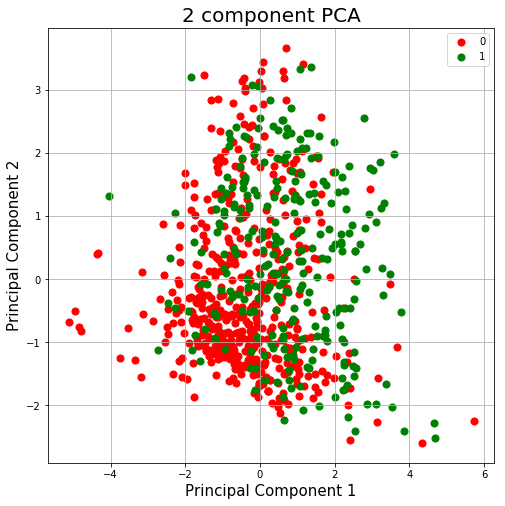

In [22]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['diabetes'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.savefig('pca.png')

## Confusion Matrix

<Figure size 432x288 with 0 Axes>

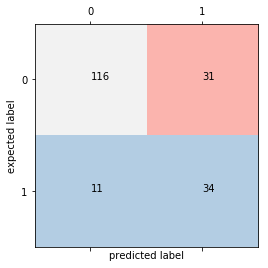

In [23]:
from sklearn import metrics

model = SVC(C=10, kernel='rbf', gamma=0.01)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
model.fit(X_train_std,y_train)
prediction = model.predict(X_test_std)


confusion_matrix = metrics.confusion_matrix(y_test, prediction)
confusion_matrix

plt.figure()
plt.matshow(confusion_matrix, cmap='Pastel1')

for x in range(0, 2):
    for y in range(0, 2):
        plt.text(x, y, confusion_matrix[x, y])
        
        
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()

In [24]:
TP = confusion_matrix[1, 1]
TN = confusion_matrix[0, 0]
FP = confusion_matrix[0, 1]
FN = confusion_matrix[1, 0]

print("Sensitivity: %.4f" % (TP / float(TP + FN)))
print("Specificy  : %.4f" % (TN / float(TN + FP)))

Sensitivity: 0.5231
Specificy  : 0.9134


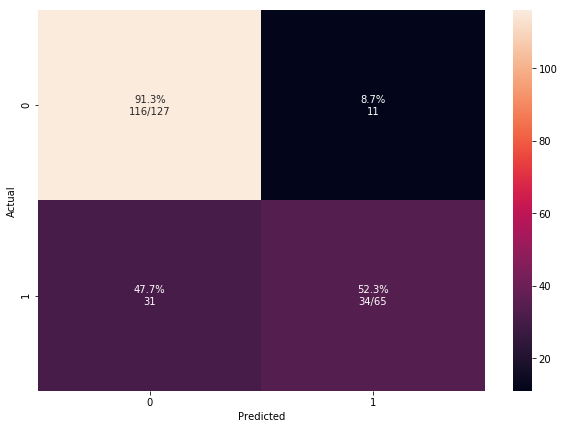

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



def cm_analysis(y_test, prediction, filename, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    
model = SVC(C=10, kernel='rbf', gamma=0.01)
model.fit(X_train_std,y_train)
prediction = model.predict(X_test_std)

cm = confusion_matrix(y_test, prediction)


cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
cm = pd.DataFrame(cm)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize = (10,7))

sns.heatmap(cm, annot=annot, fmt='', ax=ax)
#plt.savefig('cm.png')

## Learning with Ensemble

In [26]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
#from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in items(self.named_classifiers):
                for key, value in items(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [52]:
mlp1 = MLPClassifier(hidden_layer_sizes=(7,4), tol = 1e-4, alpha=10,
                    solver='lbfgs', verbose=False, random_state=1,
                    learning_rate_init=.01, warm_start=True)
mlp2 = MLPClassifier(hidden_layer_sizes=(8,8), tol = 1e-4, alpha=10,
                    solver='lbfgs', verbose=False, random_state=1,
                    learning_rate_init=.01, warm_start=True)

mlp3 = MLPClassifier(hidden_layer_sizes=(6,5), tol = 1e-4, alpha=10,
                    solver='lbfgs', verbose=False, random_state=1,
                    learning_rate_init=.01, warm_start=True)

mlp4 = MLPClassifier(hidden_layer_sizes=(8,), tol = 1e-4, alpha=10,
                    solver='lbfgs', verbose=False, random_state=1,
                    learning_rate_init=.01, warm_start=True)



svc1 = SVC(C=5, gamma =0.01, kernel='rbf', tol=0.001, max_iter = 4000, probability=True)

svc2 = SVC(C=1, gamma=0.01, kernel='rbf', tol=0.001, max_iter = 4000, probability=True)

svc3 = SVC(C=10, gamma=0.01, kernel='rbf', tol=0.001, max_iter = 4000, probability=True)
mv_clf = MajorityVoteClassifier(classifiers=[mlp1, mlp2, mlp3, mlp4, svc1, svc2, svc3])
mv_clfp = MajorityVoteClassifier(classifiers=[mlp1, mlp2, mlp3, mlp4, svc1, svc2, svc3], vote='probability')
clf_labels = ['MLP1', 'MLP2', 'MLP3', 'MLP4', 'SVC1', 'SVC2', 'SVC3','Majority voting', 'Majority probability voting']

all_clf = [mlp1, mlp2, mlp3, mlp4, svc1, svc2, svc3, mv_clf, mv_clfp]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_validate(estimator=clf,   
                            X=X_std,
                            y=y,
                            cv=5,
                            scoring=['accuracy','f1','precision','recall'],
                            return_train_score=True,
                            n_jobs=-1)
    print("\n"+label)
    print('CV train accuracy: %.3f +/- %.3f' % (np.mean(scores['train_accuracy']),
                                          np.std(scores['train_accuracy'])))
    print('CV test accuracy: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']),
                                          np.std(scores['test_accuracy'])))
    print('CV f1 score: %.3f +/- %.3f' % (np.mean(scores['test_f1']),
                                          np.std(scores['test_f1'])))
    print('CV precision: %.3f +/- %.3f' % (np.mean(scores['test_precision']),
                                          np.std(scores['test_precision'])))
    print('CV recall: %.3f +/- %.3f' % (np.mean(scores['test_recall']),
                                          np.std(scores['test_recall'])))



MLP1
CV train accuracy: 0.798 +/- 0.010
CV test accuracy: 0.766 +/- 0.024
CV f1 score: 0.630 +/- 0.044
CV precision: 0.704 +/- 0.045
CV recall: 0.575 +/- 0.069

MLP2
CV train accuracy: 0.793 +/- 0.006
CV test accuracy: 0.771 +/- 0.025
CV f1 score: 0.635 +/- 0.044
CV precision: 0.718 +/- 0.048
CV recall: 0.575 +/- 0.068

MLP3
CV train accuracy: 0.792 +/- 0.008
CV test accuracy: 0.775 +/- 0.028
CV f1 score: 0.643 +/- 0.050
CV precision: 0.719 +/- 0.047
CV recall: 0.586 +/- 0.068

MLP4
CV train accuracy: 0.789 +/- 0.008
CV test accuracy: 0.772 +/- 0.023
CV f1 score: 0.635 +/- 0.040
CV precision: 0.721 +/- 0.044
CV recall: 0.571 +/- 0.055

SVC1
CV train accuracy: 0.785 +/- 0.009
CV test accuracy: 0.776 +/- 0.021
CV f1 score: 0.635 +/- 0.037
CV precision: 0.738 +/- 0.045
CV recall: 0.560 +/- 0.049

SVC2
CV train accuracy: 0.782 +/- 0.006
CV test accuracy: 0.777 +/- 0.024
CV f1 score: 0.629 +/- 0.034
CV precision: 0.757 +/- 0.062
CV recall: 0.541 +/- 0.035

SVC3
CV train accuracy: 0.791 +/-

# Correlation between features

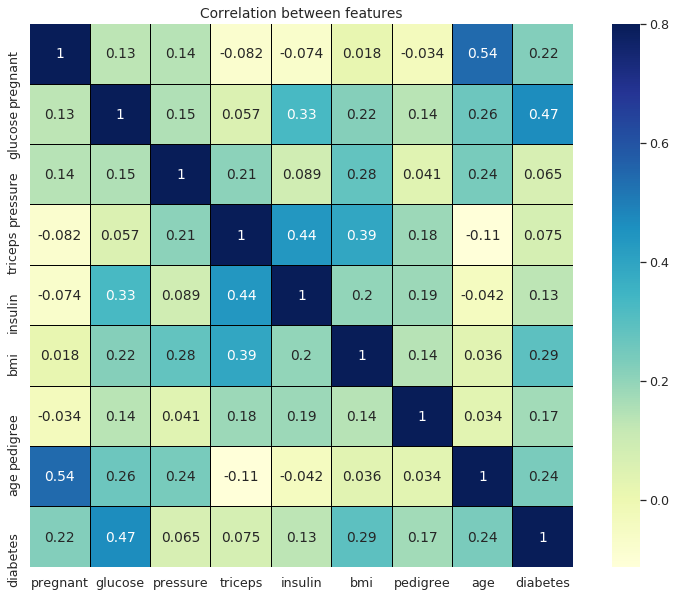

In [11]:
import seaborn as sns

corr=df.corr()

sns.set(font_scale=1.15)
plt.figure(figsize=(14, 10))

sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="black")
plt.title('Correlation between features');

/usr/lib/anaconda3/envs/tfgpu/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/lib/anaconda3/envs/tfgpu/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/lib/anaconda3/envs/tfgpu/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/usr/lib/anaconda3/envs/tfgpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axi

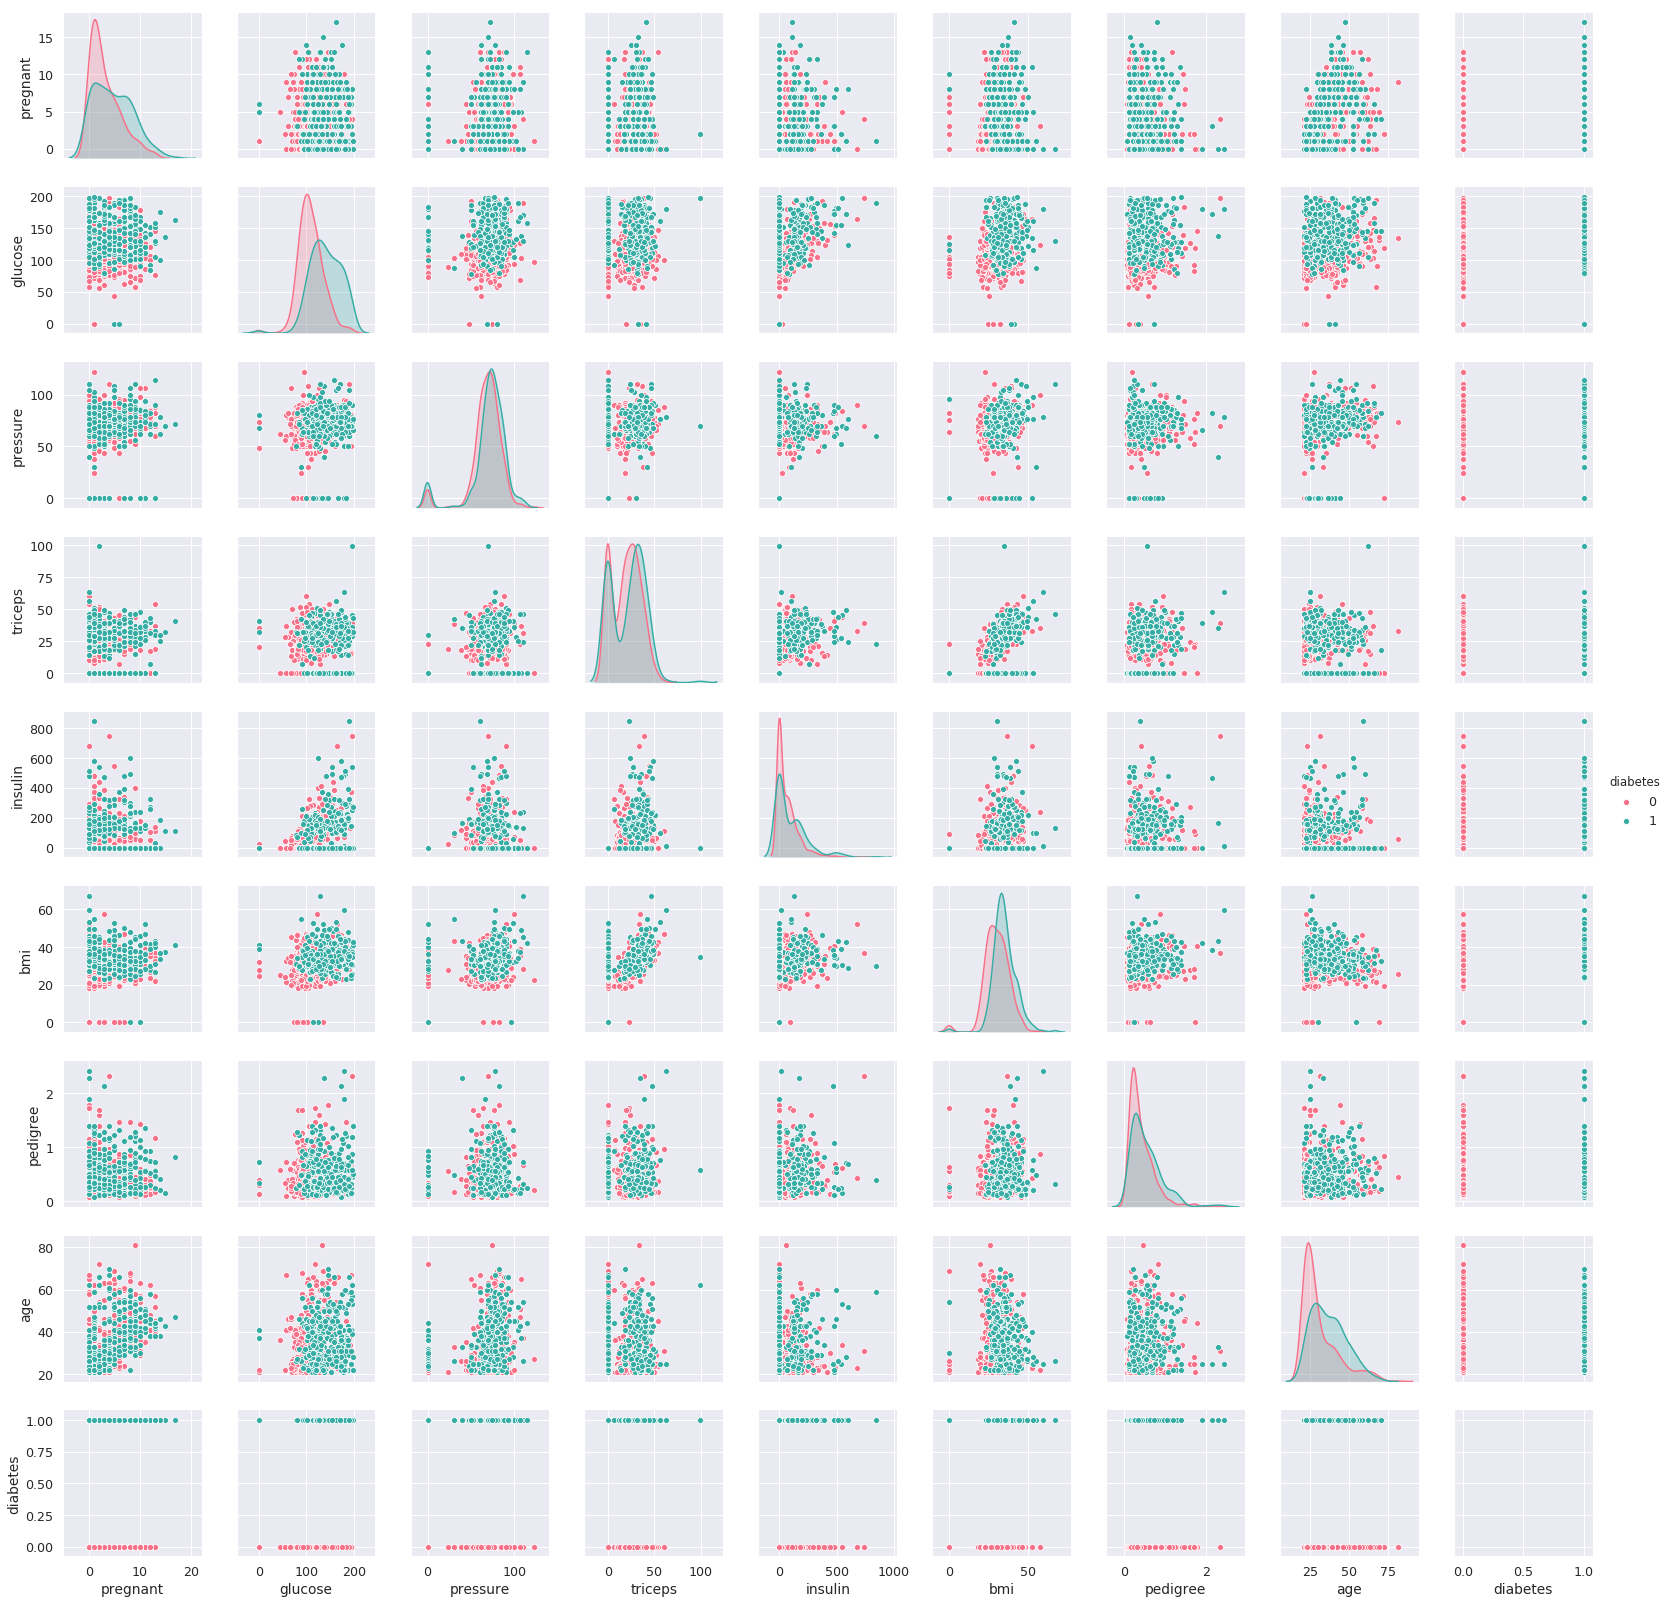

In [14]:
sns.pairplot(data=df,hue='diabetes', palette="husl")

/usr/lib/anaconda3/envs/tfgpu/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/lib/anaconda3/envs/tfgpu/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/lib/anaconda3/envs/tfgpu/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/usr/lib/anaconda3/envs/tfgpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axi

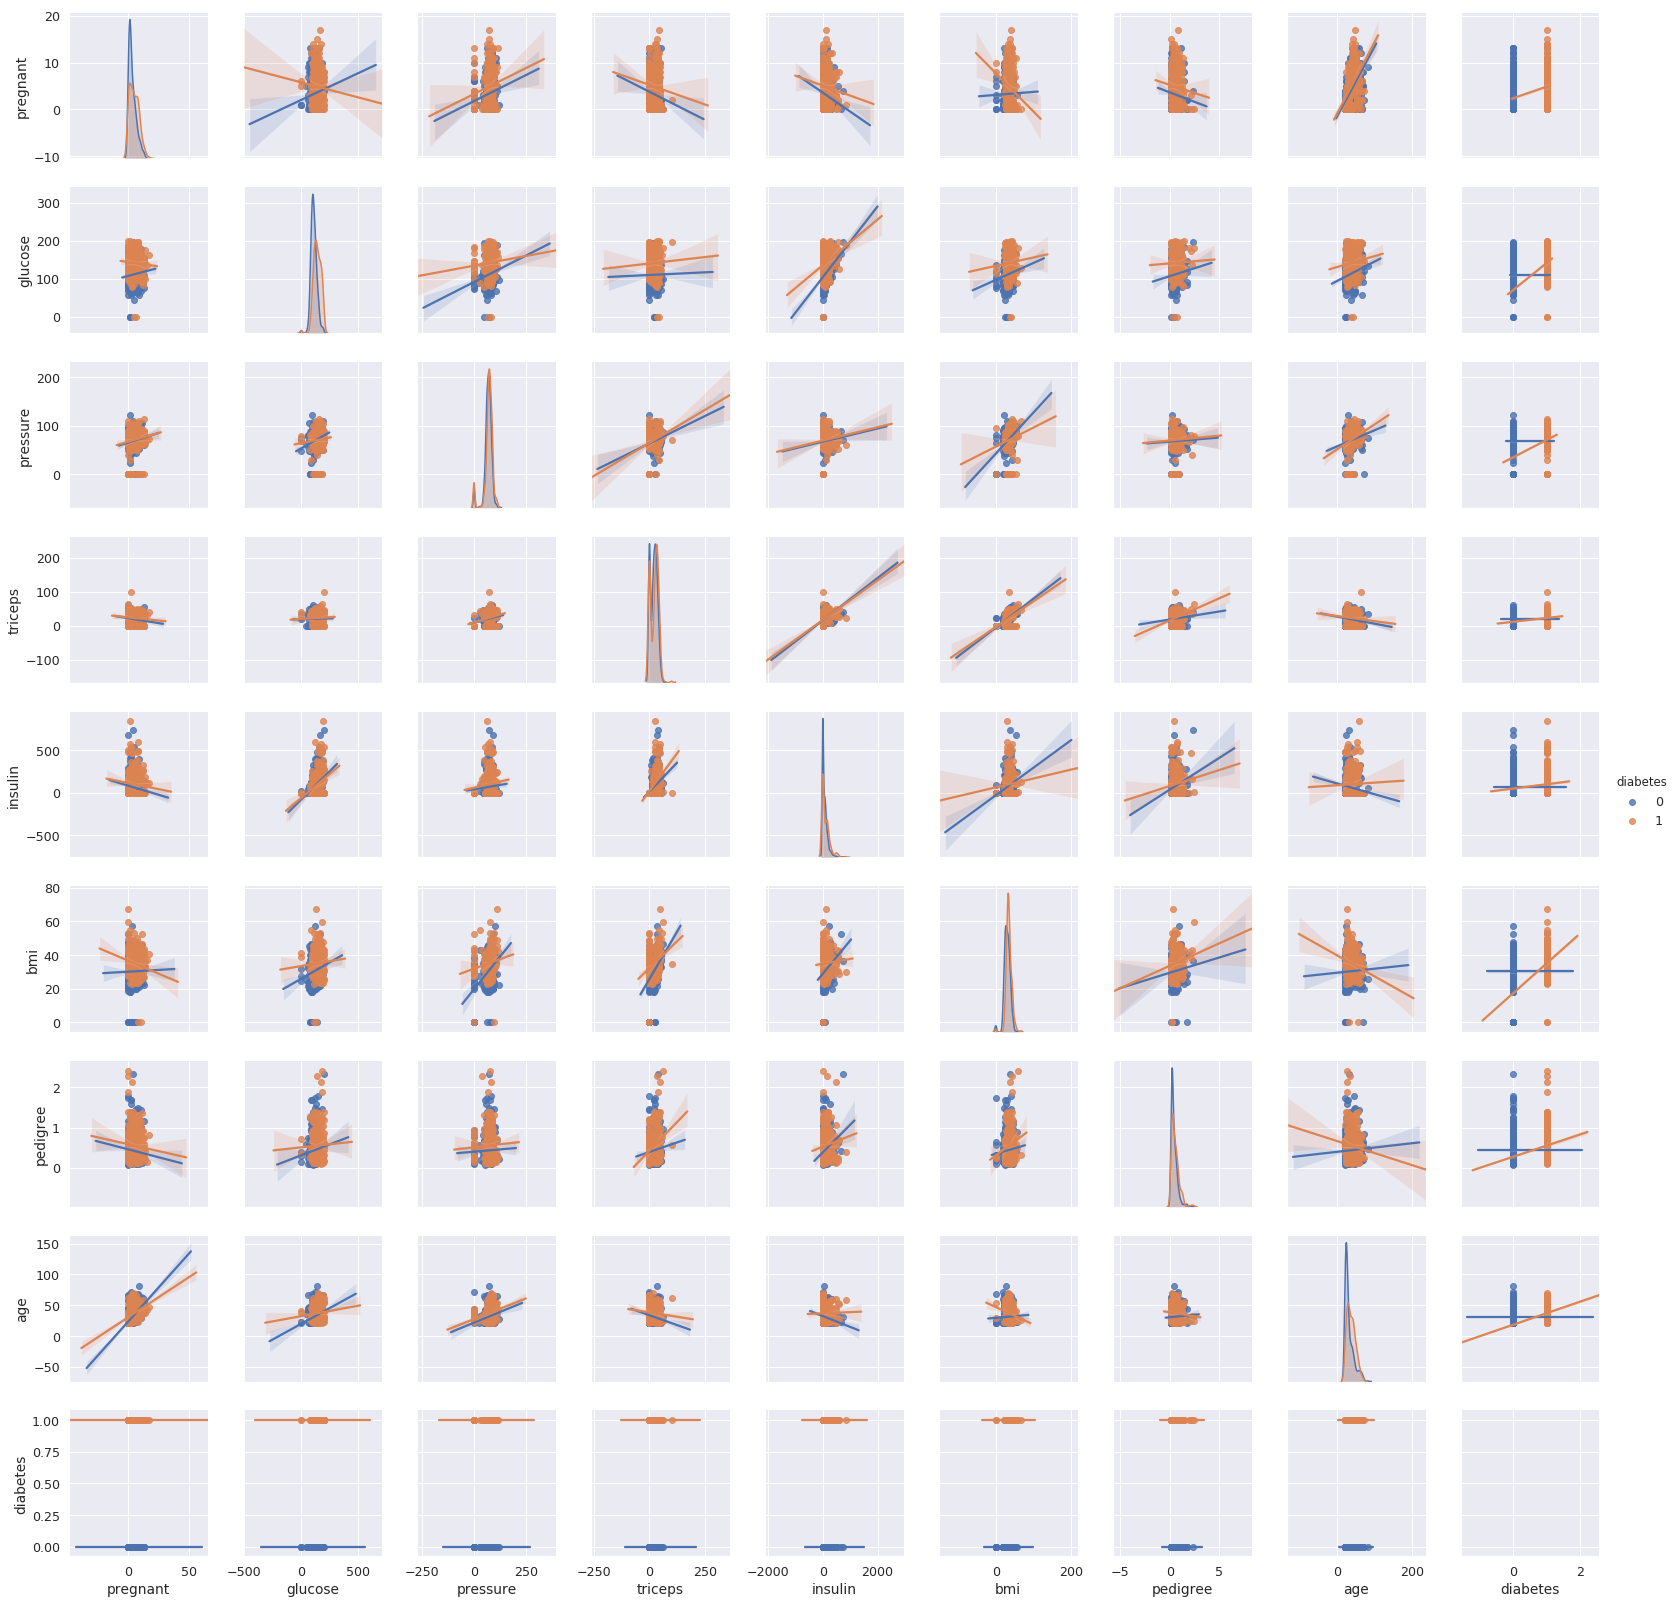

In [15]:
sns.pairplot(data=df,hue='diabetes', kind="reg")